# Lesson 06
# Peter Lorenz

In this assignment, we build a model to predict whether an individual is a PEP (politically exposed person) based on their banking data.

## 0. Preliminaries

Import the required libraries:

In [9]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

Set global options:

In [2]:
# Display plots inline
%matplotlib inline

# Display multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Declare utility functions:

## 1. Read, parse, and pre-process the data
In this section, we read, parse, and pre-process the data.

In [3]:
# Internet location of the data set
url = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Bank%20Data.csv"

# Download the data into a dataframe object
bank_data = pd.read_csv(url)

# Display shape and initial data
bank_data.shape
bank_data.head()

# Examine column types
bank_data.info()

(600, 11)

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,FEMALE,INNER_CITY,17546.000,NO,1,NO,NO,NO,NO,YES
1,40,MALE,TOWN,30085.100,YES,3,YES,NO,YES,YES,NO
2,51,FEMALE,INNER_CITY,16575.400,YES,0,YES,YES,YES,NO,NO
3,23,FEMALE,TOWN,20375.400,YES,3,NO,NO,YES,NO,NO
4,57,FEMALE,RURAL,50576.300,YES,0,NO,YES,NO,NO,NO


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          600 non-null    int64  
 1   sex          600 non-null    object 
 2   region       600 non-null    object 
 3   income       600 non-null    float64
 4   married      600 non-null    object 
 5   children     600 non-null    int64  
 6   car          600 non-null    object 
 7   save_act     600 non-null    object 
 8   current_act  600 non-null    object 
 9   mortgage     600 non-null    object 
 10  pep          600 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 51.7+ KB


First we have to deal with categorical columns, converting these to one-hot-encoded format:

In [7]:
# Use pandas to one-hot encode categorical variables as k-1 dummies per column
bank_data_enc = pd.get_dummies(bank_data, 
                               columns=["sex", "region", "married", "children", "car", 
                                        "save_act", "current_act", "mortgage", "pep"
                                       ], 
                               drop_first=True)

# Display shape and sample contents
bank_data_enc.shape
bank_data_enc.head()

# Examine column types
bank_data_enc.info()

(600, 15)

,age,income,sex_MALE,region_RURAL,region_SUBURBAN,region_TOWN,married_YES,children_1,children_2,children_3,car_YES,save_act_YES,current_act_YES,mortgage_YES,pep_YES
0,48,17546.000,0,0,0,0,0,1,0,0,0,0,0,0,1
1,40,30085.100,1,0,0,1,1,0,0,1,1,0,1,1,0
2,51,16575.400,0,0,0,0,1,0,0,0,1,1,1,0,0
3,23,20375.400,0,0,0,1,1,0,0,1,0,0,1,0,0
4,57,50576.300,0,1,0,0,1,0,0,0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              600 non-null    int64  
 1   income           600 non-null    float64
 2   sex_MALE         600 non-null    uint8  
 3   region_RURAL     600 non-null    uint8  
 4   region_SUBURBAN  600 non-null    uint8  
 5   region_TOWN      600 non-null    uint8  
 6   married_YES      600 non-null    uint8  
 7   children_1       600 non-null    uint8  
 8   children_2       600 non-null    uint8  
 9   children_3       600 non-null    uint8  
 10  car_YES          600 non-null    uint8  
 11  save_act_YES     600 non-null    uint8  
 12  current_act_YES  600 non-null    uint8  
 13  mortgage_YES     600 non-null    uint8  
 14  pep_YES          600 non-null    uint8  
dtypes: float64(1), int64(1), uint8(13)
memory usage: 17.1 KB


One challenge is how to represent the age column in our data set. The column is sequential and, hence, an age of 42 is more related to an age of 41 than, say, an age of 20. Yet the column is also categorical in that a person who is 40 is not in any sense "twice" a person who is 20. It seems preferable to represent age as a series of bins. First we determine the range of ages:

In [15]:
# Display max and min ages
print('Min age is', bank_data_enc['age'].min())
print('Max age is', bank_data_enc['age'].max())

Min age is 18
Max age is 67


The range of ages is essentially the "working" ages from 18 to 67. One straightforward way to bin the data is by decade: 20's, 30's, 40's, 50's, 60's. For convenience, we combine ages 18 and 19 with the 20's.

In [50]:
# Bin age by decade
bank_data_enc['is_twenties'] = np.array((bank_data_enc['age'] >= 18).astype(int) & 
                                        (bank_data_enc['age'] < 30).astype(int))
bank_data_enc['is_thirties'] = np.array((bank_data_enc['age'] >= 30).astype(int) & 
                                        (bank_data_enc['age'] < 40).astype(int))
bank_data_enc['is_forties'] = np.array((bank_data_enc['age'] >= 40).astype(int) & 
                                       (bank_data_enc['age'] < 50).astype(int))
bank_data_enc['is_fifties'] = np.array((bank_data_enc['age'] >= 50).astype(int) & 
                                        (bank_data_enc['age'] < 60).astype(int))
bank_data_enc['is_sixties'] = np.array((bank_data_enc['age'] >= 60).astype(int))

# Display shape and sample contents
bank_data_enc.shape
bank_data_enc.head()

# Examine column types
bank_data_enc.info()

(600, 19)

,age,income,sex_MALE,region_RURAL,region_SUBURBAN,region_TOWN,married_YES,children_1,children_2,children_3,car_YES,save_act_YES,current_act_YES,mortgage_YES,is_twenties,is_thirties,is_forties,is_fifties,is_sixties
0,48,17546.000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,40,30085.100,1,0,0,1,1,0,0,1,1,0,1,1,0,0,1,0,0
2,51,16575.400,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0
3,23,20375.400,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0
4,57,50576.300,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              600 non-null    int64  
 1   income           600 non-null    float64
 2   sex_MALE         600 non-null    uint8  
 3   region_RURAL     600 non-null    uint8  
 4   region_SUBURBAN  600 non-null    uint8  
 5   region_TOWN      600 non-null    uint8  
 6   married_YES      600 non-null    uint8  
 7   children_1       600 non-null    uint8  
 8   children_2       600 non-null    uint8  
 9   children_3       600 non-null    uint8  
 10  car_YES          600 non-null    uint8  
 11  save_act_YES     600 non-null    uint8  
 12  current_act_YES  600 non-null    uint8  
 13  mortgage_YES     600 non-null    uint8  
 14  is_twenties      600 non-null    int32  
 15  is_thirties      600 non-null    int32  
 16  is_forties       600 non-null    int32  
 17  is_fifties      

We lose some information concerning the sequential nature of the data, but avoid the meaninglessness of implying that numerical operations apply to ages. We now drop the original age column:

In [53]:
# Drop age column
bank_data_enc = bank_data_enc.drop(['age'], axis=1)

# Display shape and sample contents
bank_data_enc.shape
bank_data_enc.head()

# Examine column types
bank_data_enc.info()

(600, 18)

,income,sex_MALE,region_RURAL,region_SUBURBAN,region_TOWN,married_YES,children_1,children_2,children_3,car_YES,save_act_YES,current_act_YES,mortgage_YES,is_twenties,is_thirties,is_forties,is_fifties,is_sixties
0,17546.000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,30085.100,1,0,0,1,1,0,0,1,1,0,1,1,0,0,1,0,0
2,16575.400,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0
3,20375.400,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0
4,50576.300,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   income           600 non-null    float64
 1   sex_MALE         600 non-null    uint8  
 2   region_RURAL     600 non-null    uint8  
 3   region_SUBURBAN  600 non-null    uint8  
 4   region_TOWN      600 non-null    uint8  
 5   married_YES      600 non-null    uint8  
 6   children_1       600 non-null    uint8  
 7   children_2       600 non-null    uint8  
 8   children_3       600 non-null    uint8  
 9   car_YES          600 non-null    uint8  
 10  save_act_YES     600 non-null    uint8  
 11  current_act_YES  600 non-null    uint8  
 12  mortgage_YES     600 non-null    uint8  
 13  is_twenties      600 non-null    int32  
 14  is_thirties      600 non-null    int32  
 15  is_forties       600 non-null    int32  
 16  is_fifties       600 non-null    int32  
 17  is_sixties      

Next we extract the target variable:

In [8]:
# Extract and reserve the target column
is_pep = np.array(bank_data_enc['pep_YES'].values)
bank_data_enc = bank_data_enc.drop(['pep_YES'], axis=1)

We can now proceed to exploratory analysis.

## 2. Perform exploratory analysis
In this section, we perform a brief exploratory analysis, beginning with an analysis of column distributions.
### Column distributions
Here we examine the column distributions per column.

#### Age

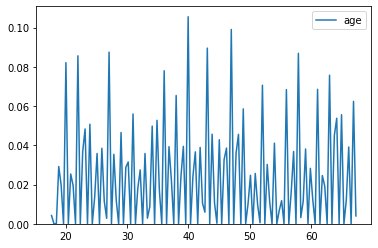

In [10]:
sns.kdeplot(bank_data_enc['age'], bw = 0.1)

The distribution of the age column appears somewhat random. One challenge is how to represent this column in our data set. The column is sequential and, hence, an age of 42 is more related to an age of 41 than, say, an age of 20. Yet the column is also discrete in that a person who is 40 is not in any sense "twice" a person who is 20. It seems preferable to represent age as a series of bins.

## 3. Compare the performance of decision tree and random forest approaches
In this section, we compare the performance between a decision tree and a random forest approach by assessing the accuracy of each model.

## 4. Graph structure of the decision tree
In this section, we graph the structure of our decision tree.

## 5. Graph the confusion matrix of your random forest model
In this section, we graph the confusion matrix of our random forest model.